# Introducrtion to Machine Learning: Assignment #4
## Submission date: 31\07\2024, 23:55.
### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

Submitted by:

 **Student 1 Name+ID

 **Student 2 Name+ID

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Bagging
In HW3, you helped Charles Darvin with regression of abalone problem and now, you will try combining multiple regression models instead of just one, hopefully for a better result.

In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

In [2]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Your task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [3]:
from sklearn.linear_model import LinearRegression

class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Sampling data with replacement
            indices = np.random.choice(len(data), len(data), replace=True)
            sample_data = data[indices]
            sample_targets = targets[indices]

            # Training a Linear Regression model
            regressor = LinearRegression()
            regressor.fit(sample_data, sample_targets)

            # Storing the trained model
            self.regressors.append(regressor)

    def predict(self, test):
        preds = np.zeros((len(test), len(self.regressors))) # Initializing a matrx to store predictions

        # Getting predictions from all the regressors
        for i, regressor in enumerate(self.regressors):
            preds[:, i] = regressor.predict(test)

        # Average of the predictions
        return np.mean(preds, axis=1)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)


In [4]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.807938092578447
MSE test = 5.382913306550463


Now, implement the same but using ridge regression

In [5]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Sampling data with replacement as before
            indices = np.random.choice(len(data), len(data), replace=True)
            sample_data = data[indices]
            sample_targets = targets[indices]

            # Training a Ridge Regression model
            regressor = Ridge(alpha=self.alpha)
            regressor.fit(sample_data, sample_targets)

            # Storing the trained model
            self.regressors.append(regressor)

    def predict(self, test): # Same as LinRegCombiner predict
        preds = np.zeros((len(test), len(self.regressors)))
        for i, regressor in enumerate(self.regressors):
            preds[:, i] = regressor.predict(test)
        return np.mean(preds, axis=1)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)


Tune the hyperparameters for RidgeLinRegCombiner.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Defining the parameter grid to tune
param_grid = {
    'ridgecombiner__n_estimators': [50, 100, 200, 300],
    'ridgecombiner__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Creating a pipeline with standard scaling and the RidgeLinRegCombiner
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Assuming you need scaling
    ('ridgecombiner', RidgeLinRegCombiner(n_estimators=10, alpha=1.0))
])

# Defining a custom scoring function (MSE)
# `make_scorer` creates a scorer object that can be used in model evaluation.
# `mean_squared_error` is the metric used for scoring that we have planned to use.
# `greater_is_better=False` indicates that a lower score is better. This is because MSE is a loss function,
# where lower values are better (indicating a model with less error).
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Printing the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'ridgecombiner__alpha': 0.001, 'ridgecombiner__n_estimators': 100}
Best score: -4.91076337727781


Print both MSEs on train and test.
Which model is better for our problem? <br/>

<font color='red'>
The model may be overfitting, as the test error is higher than the training error.

Based on the MSE results on both the training and test datasets, the model's performance can be evaluated. Ideally, the test MSE should be close to the training MSE, indicating good generalization.

In this case, based on the MSE values, the RidgeLinRegCombiner will generalize better the data, being a better model than LinRegCombiner.
</font>


In [7]:
# Extracting the best n_estimators and alpha
n = best_params['ridgecombiner__n_estimators']
alpha = best_params['ridgecombiner__alpha']

# Running for the best parameters
obj = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
obj.fit(X_train, y_train)

mse_train = obj.score(X_train, y_train)
print(f'MSE train = {mse_train}')

mse_test = obj.score(X_test, y_test)
print(f'MSE test = {mse_test}')

MSE train = 4.809715842673413
MSE test = 5.38077776281156


## Question 2 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [9]:
import numpy as np

class Kmeans:

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def reassign_centroids(self, X, labels):
            centroids = np.zeros((self.n_clusters, X.shape[1]))

            # for each cluster
            for k in range(self.n_clusters):
                # Calculating the mean of all points assigned to cluster k
                # This mean vector becomes the new centroid for cluster k
                centroids[k] = X[labels == k].mean(axis=0)

            # Return the updated centroids
            return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            # For each point: calculating distance to all k clusters
            distance = self.compute_distance(X, old_centroids)
            # Assigning the labels with closest distance' cluster
            self.labels = self.find_closest_cluster(distance)
            # Updating the centroids
            self.centroids = self.reassign_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)

    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)


Load exams data, convert to numpy and plot it

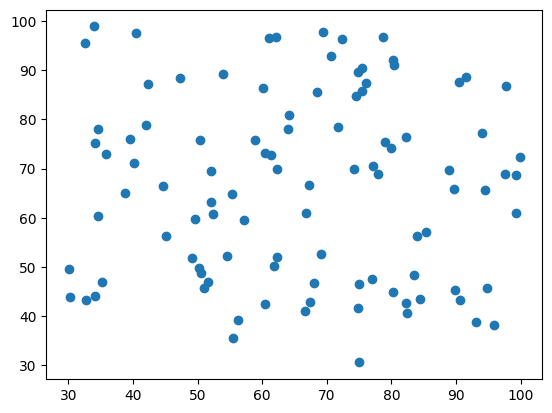

In [10]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

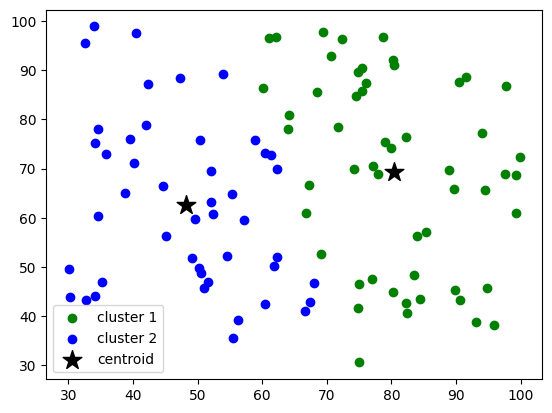

In [11]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='red'>My choice is 3 neighbors, since this is the more visible elbow like figure in the graph</font>

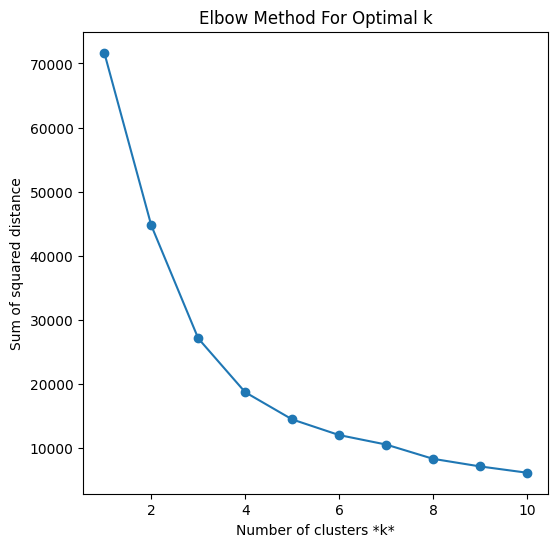

In [12]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
    kmeans = Kmeans(n_clusters=k)
    kmeans.fit(data)
    sse.append(kmeans.error)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal k')
plt.show()

Apply clustering with the selected k

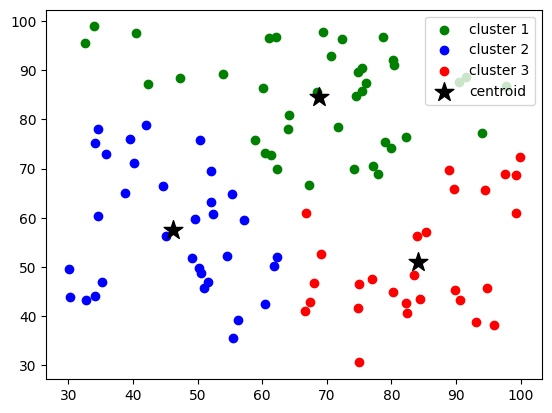

In [13]:
# Applying clustering with k = 3
clust = Kmeans(n_clusters=3)
clust.fit(data)

# Labels and centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]
c2 = data[labels == 2]

# Plot of the data and clusters with the centroids
plt.scatter(c0[:, 0], c0[:, 1], c='green', label='cluster 1')
plt.scatter(c1[:, 0], c1[:, 1], c='blue', label='cluster 2')
plt.scatter(c2[:, 0], c2[:, 1], c='red', label='cluster 3')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()
plt.show()

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [14]:
#@title helper function
import cv2
import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

In [15]:
from sklearn.cluster import KMeans

# Read the image
img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape the image to be 2-dimensional
X = img.reshape(img_size[0] * img_size[1], img_size[2])  # Turn hxwx3 into (h*w)x3

# Run the KMeans algorithm
km = KMeans(n_clusters=20, random_state=123)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, ), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
    For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_]
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape img_compressed to have the same dimension as the original image
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

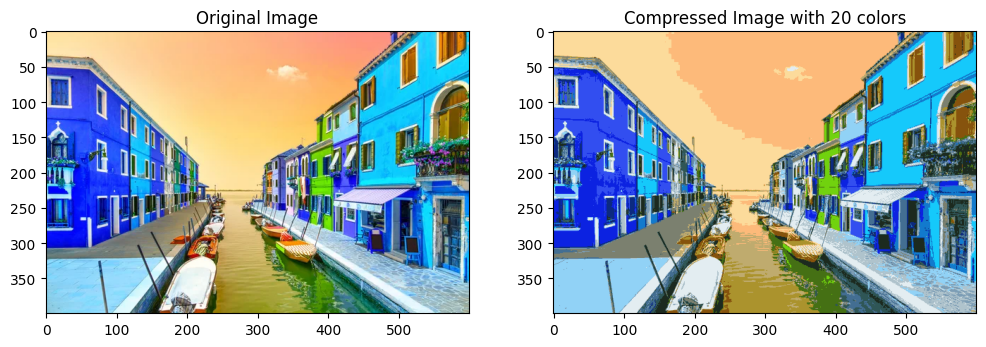

In [16]:
# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [17]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle.json
ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                     📚 Students Performance Dataset 📚                  66KB  2024-06-12 23:09:20          11421        239  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024               Most Streamed Spotify Songs 2024                 496KB  2024-06-15 18:50:51           8750        179  1.0              
dataanalyst001/world-population-by-country-2024                 World Population by country 2024                   6KB  2024-07-04 09:47:58           1214         26  1.0              
ihelon/coffee-sales                      

import libraries

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [19]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

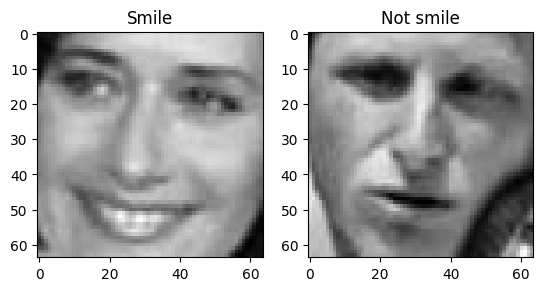

In [20]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [21]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Question 3 - PCA, LDA

You will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9.

1.   Elemento de la lista
2.   Elemento de la lista

For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [24]:
def PCA_train(data, k):
    pca = PCA(n_components=k)
    # PCA model fit
    transformed_data = pca.fit_transform(data)

    # Return the transformed data, the mean of the original data, the components, and the eigenvalues
    return transformed_data, pca.mean_, pca.components_, pca.explained_variance_

def PCA_test(test, mu, E):
    centered_data = test - mu # Subtract the mean from the test data
    transformed_data = np.dot(centered_data, E.T) # Project the centered data into the components
    return transformed_data

def recover_PCA(data, mu, E):
    # Recover the original data by adding the mean to the dot product of the data and the components
    recovered_data = np.dot(data, E) + mu
    return recovered_data

Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [25]:
x_train_new, mu, E, _ = PCA_train(x_train_flatten, 81)
x_test_new = PCA_test(x_test_flatten, mu, E)

Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

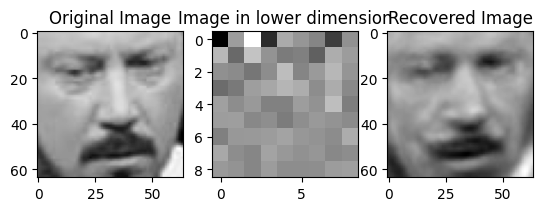

In [26]:
# Selecting an image, applying PCA and recovering the image
random_image = x_train[0]
pca_image = PCA_test(random_image.flatten().reshape(1, -1), mu, E)
recovered_image = recover_PCA(pca_image, mu, E)

plt.subplot(131)
plt.title("Original Image")
plt.imshow(random_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(pca_image.reshape(9, 9), cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image.reshape(random_image.shape), cmap='gray')

plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

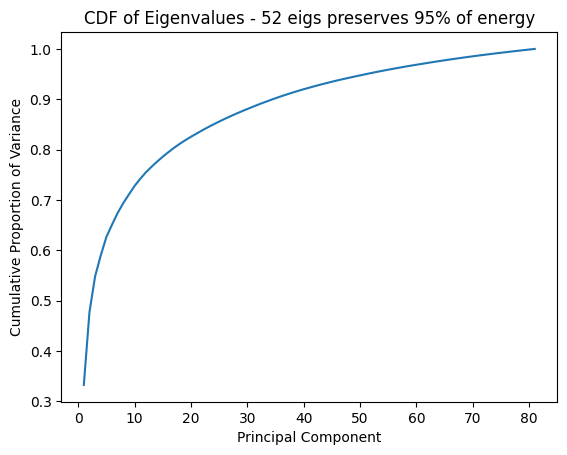

In [27]:
def EIG_CDF(eig_list):
    sorted_eigenvalues = np.sort(eig_list)[::-1]

    eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)

    eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]

    # Finding the number of eigenvalues that preserve 95% of the total variance
    amount = np.argmax(eigenvalues_cumsum_normalized >= 0.95) + 1

    plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Proportion of Variance')
    plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of energy')
    plt.show()
    return amount

# Call to EIG_CDF
amount = EIG_CDF(_)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='red'>
As anticipated, utilizing 81 dimensions enhances the quality and detail of the reconstructed image. However, it is unexpectedly similar to the results achieved using the optimal dimensions determined through EIG. This similarity suggests that nearly identical outcomes can be obtained with images of reduced dimensions.
</font>

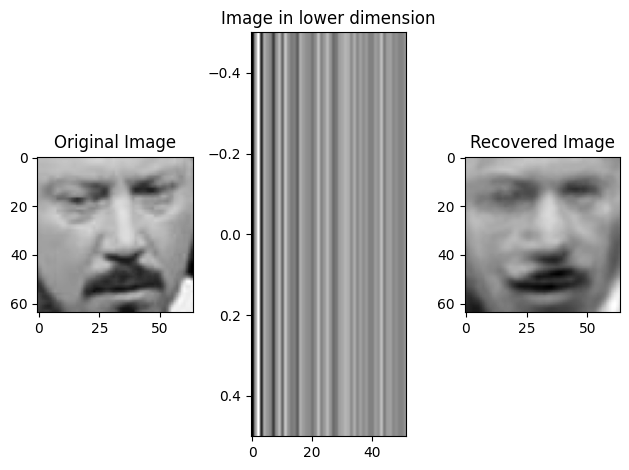

In [28]:
# Applying PCA with the optimal number of dimensions
x_train_optimal, mu_optimal, E_optimal, _ = PCA_train(x_train_flatten, amount)
x_test_optimal = PCA_test(x_test_flatten, mu_optimal, E_optimal)

random_image = x_train[0]
pca_image_optimal = PCA_test(random_image.flatten().reshape(1, -1), mu_optimal, E_optimal) # PCA
recovered_image_optimal = recover_PCA(pca_image_optimal, mu_optimal, E_optimal) # Recover

plt.subplot(131)
plt.title("Original Image")
plt.imshow(random_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
# Display the PCA image as a 1D image
plt.imshow(pca_image_optimal.reshape(1, -1), cmap='gray', aspect='auto')

plt.subplot(133)
plt.title("Recovered Image")
# Reshaping the recovered image to its original size before displaying it
plt.imshow(recovered_image_optimal.reshape(random_image.shape), cmap='gray')
plt.tight_layout()

plt.show()

Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

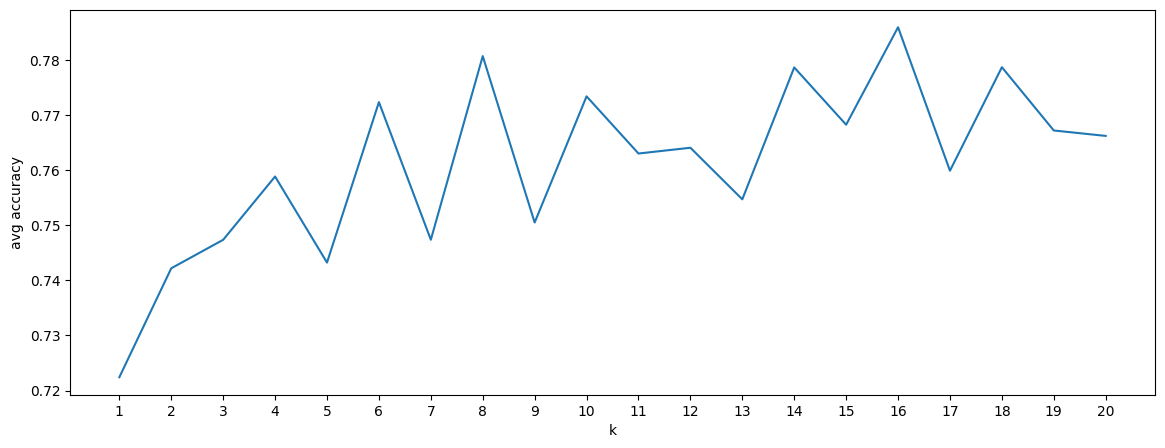

In [29]:
ks = range(1, 21) # range of k values
accs = [] # Accuracys

# For each k, train a KNN model and calculate the cross-validation score
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_optimal, y_train, cv=5)
    accs.append(scores.mean())

plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [30]:
from sklearn.metrics import accuracy_score

# Fit the model on the training data
k_optimal = ks[np.argmax(accs)]
print(k_optimal)
knn_optimal = KNeighborsClassifier(n_neighbors=k_optimal)
knn_optimal.fit(x_train_optimal, y_train)

# Predict the labels of the test data
y_pred = knn_optimal.predict(x_test_optimal)

# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)

print(f'acc on test is {acc}')

16
acc on test is 0.8008298755186722


Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?
- Should we apply Standard Scaler? Why?
- Suggest one idea for improvement (rather than LDA)

<font color='red'>

### What pre-processing actions were done on the data?

- **Image Loading and Grayscale Conversion:** Images were loaded from a specified folder, and each image was converted from BGR to grayscale to simplify the data and reduce the computational load.
- **Normalization:** The grayscale images were normalized by dividing by 255, scaling the pixel values to the range [0, 1] to facilitate model training.
- **Train-Test Split:** The dataset was divided into training and testing sets using train_test_split with a stratifie split to maintain the proportion of labels.
- **Flattening:** The images were flattened from 2D arrays into 1D arrays to prepare them for PCA and KNN models.
- **PCA (Principal Component Analysis):** PCA was applied to the training and testing data to reduce the dimensionality of the data, retaining the components that explain the most variance.

### Should we apply Standard Scaler? Why?

Yes, we should apply StandardScaler. PCA is sensitive to the scale of the data because it relies on the variance of the features, sttandardizing the data ensures that all features contribute equally to the PCA, preventing features with larger scales from dominating the principal components.

### Suggest one idea for improvement (rather than LDA)

One idea for improvement could be to use data augmentation, by applying transformations such as rotations, translations, and scaling to the training images, we can artificially increase the size of the training dataset, which can help improve the generalization of the model and prevent overfitting.

</font>

For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Applying LDA before PCA
lda = LinearDiscriminantAnalysis()
x_train_lda = lda.fit_transform(x_train_flatten, y_train)
x_test_lda = lda.transform(x_test_flatten)

# Using the best k from earlier
k_optimal = ks[np.argmax(accs)]
knn_lda = KNeighborsClassifier(n_neighbors=k_optimal)
knn_lda.fit(x_train_lda, y_train)

# Predicting the labels of the test data
y_pred_lda = knn_lda.predict(x_test_lda)

# Accuracy calculation
acc_lda = accuracy_score(y_test, y_pred_lda)

print(f'Accuracy with LDA before PCA: {acc_lda}')

Accuracy with LDA before PCA: 0.8008298755186722


Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?
- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.

<font color='red'>

- Yes, the combination of PCA and LDA was more helpful than LDA alone. The accuracy with LDA before PCA was 0.8008, while the accuracy with the combination of PCA and LDA was 0.8880. This shows that adding PCA before LDA improved the model's performance, likely because PCA helped in removing noise and retaining the most significant features, which then allowed LDA to further optimize the class separation.

- For this problem, the combination of PCA followed by LDA was better than using PCA or LDA alone. This is evident from the higher accuracy obtained with the combination approach (0.8880) compared to LDA alone (0.8008). While LDA is effective in maximizing class separation, PCA helps in reducing the dimensionality by retaining the most significant features, thus improving the overall performance when used together. In contrast, PCA alone may not leverage the label information effectively for classification tasks, and LDA alone might not handle high-dimensional data as efficiently.

</font>

In [32]:
# Applying LDA after PCA
lda_after_pca = LinearDiscriminantAnalysis()
x_train_lda_after_pca = lda_after_pca.fit_transform(x_train_optimal, y_train)
x_test_lda_after_pca = lda_after_pca.transform(x_test_optimal)

# Almost the same code as above
knn_lda_after_pca = KNeighborsClassifier(n_neighbors=k_optimal)
knn_lda_after_pca.fit(x_train_lda_after_pca, y_train)
y_pred_lda_after_pca = knn_lda_after_pca.predict(x_test_lda_after_pca)
acc_lda_after_pca = accuracy_score(y_test, y_pred_lda_after_pca)

print(f'Accuracy with LDA after PCA: {acc_lda_after_pca}')

Accuracy with LDA after PCA: 0.8879668049792531


## Question 4 - Adaboost
See attached pdf in moodle assignment!

<font color='red'>

### 1) Classifier Error and Weight

To address the first question, we analyze the classifications:
- Points on the left (positive) side: 3 with $+1$, 1 with $-1$
- Points on the right (negative) side: 2 with $-1$

Thus, there is 1 misclassified instance on the positive side ($-1$ point) and 0 misclassified instances on the negative side.

The total number of misclassified instances is 1, and the total number of instances is 6. Therefore, the classifier error $\varepsilon_1$ is calculated as:
$ \varepsilon_1 = \frac{1}{6} = 0.17 $

To find $\alpha_1$, we use the formula:
$ \alpha_1 = 0.5 \times \log\left(\frac{1 - \varepsilon_1}{\varepsilon_1}\right) $

Plugging in $\varepsilon_1 = 0.17$, we get:
$ \alpha_1 = 0.5 \times \log\left(\frac{0.83}{0.17}\right) = 0.5 \times \log(4.88) = 0.79 $

Thus, for the first decision stump, the classifier error $\varepsilon_1$ is 0.17, and the weight $\alpha_1$ is 0.79.

### 2) New Sample Weights

To determine the new weights for the samples in the next iteration of the AdaBoost algorithm, we use the formula:
$ w_i^{(t+1)} = w_i^{(t)} \times \exp(-\alpha_t y_i h_t(x_i)) $

Where:
- $ w_i^{(t)} $ is the weight of sample $ i $ at iteration $ t $
- $ \alpha_t $ is the weight of the weak learner at iteration $ t $
- $ y_i $ is the true label of sample $ i $ (-1 or +1)
- $ h_t(x_i) $ is the prediction of the weak learner at iteration $ t $ for sample $ i $

Given the classifier's error $\varepsilon_1 = 0.17$ and the weight $\alpha_1 = 0.79$, we calculate the new weights and then normalize them to ensure they sum to 1.

For each sample:
- If correctly classified:
$ w_i^{(2)} = w_i^{(1)} \times \exp(-\alpha_1) = \frac{1}{6} \times \exp(-0.79) = 0.075 $

- If misclassified:
$ w_i^{(2)} = w_i^{(1)} \times \exp(\alpha_1) = \frac{1}{6} \times \exp(0.79) = 0.37 $

After calculating the new weights, we normalize them so their sum equals 1.

Given there are 5 correctly classified instances and 1 misclassified, their sum is $5 \times 0.075 + 0.37 = 0.75$. Then, we normalize by following this rule:
$ \text{New normalized weight} = \frac{\text{Weight}}{\text{Sum of all weights}} $

For correctly classified samples normalized:
$ w_i^{(2)} = \frac{0.075}{0.75} = 0.1 $

For misclassified samples normalized:
$ w_i^{(2)} = \frac{0.37}{0.75} = 0.49 $

We verify this by calculating $5 \times w_i^{(2)} + w_i^{(2)} = 5 \times 0.1 + 0.49 = 0.99$, which is approximately 1 due to computational errors.

### 3) Second Decision Stump

To draw the second decision stump, we need to determine the orientation (parallel to the x-axis or y-axis) and the location that minimizes the weighted error based on the updated sample weights from the previous step. Since the weighted sample in this case is the bottom right $-1$ point, the second decision stump will be:

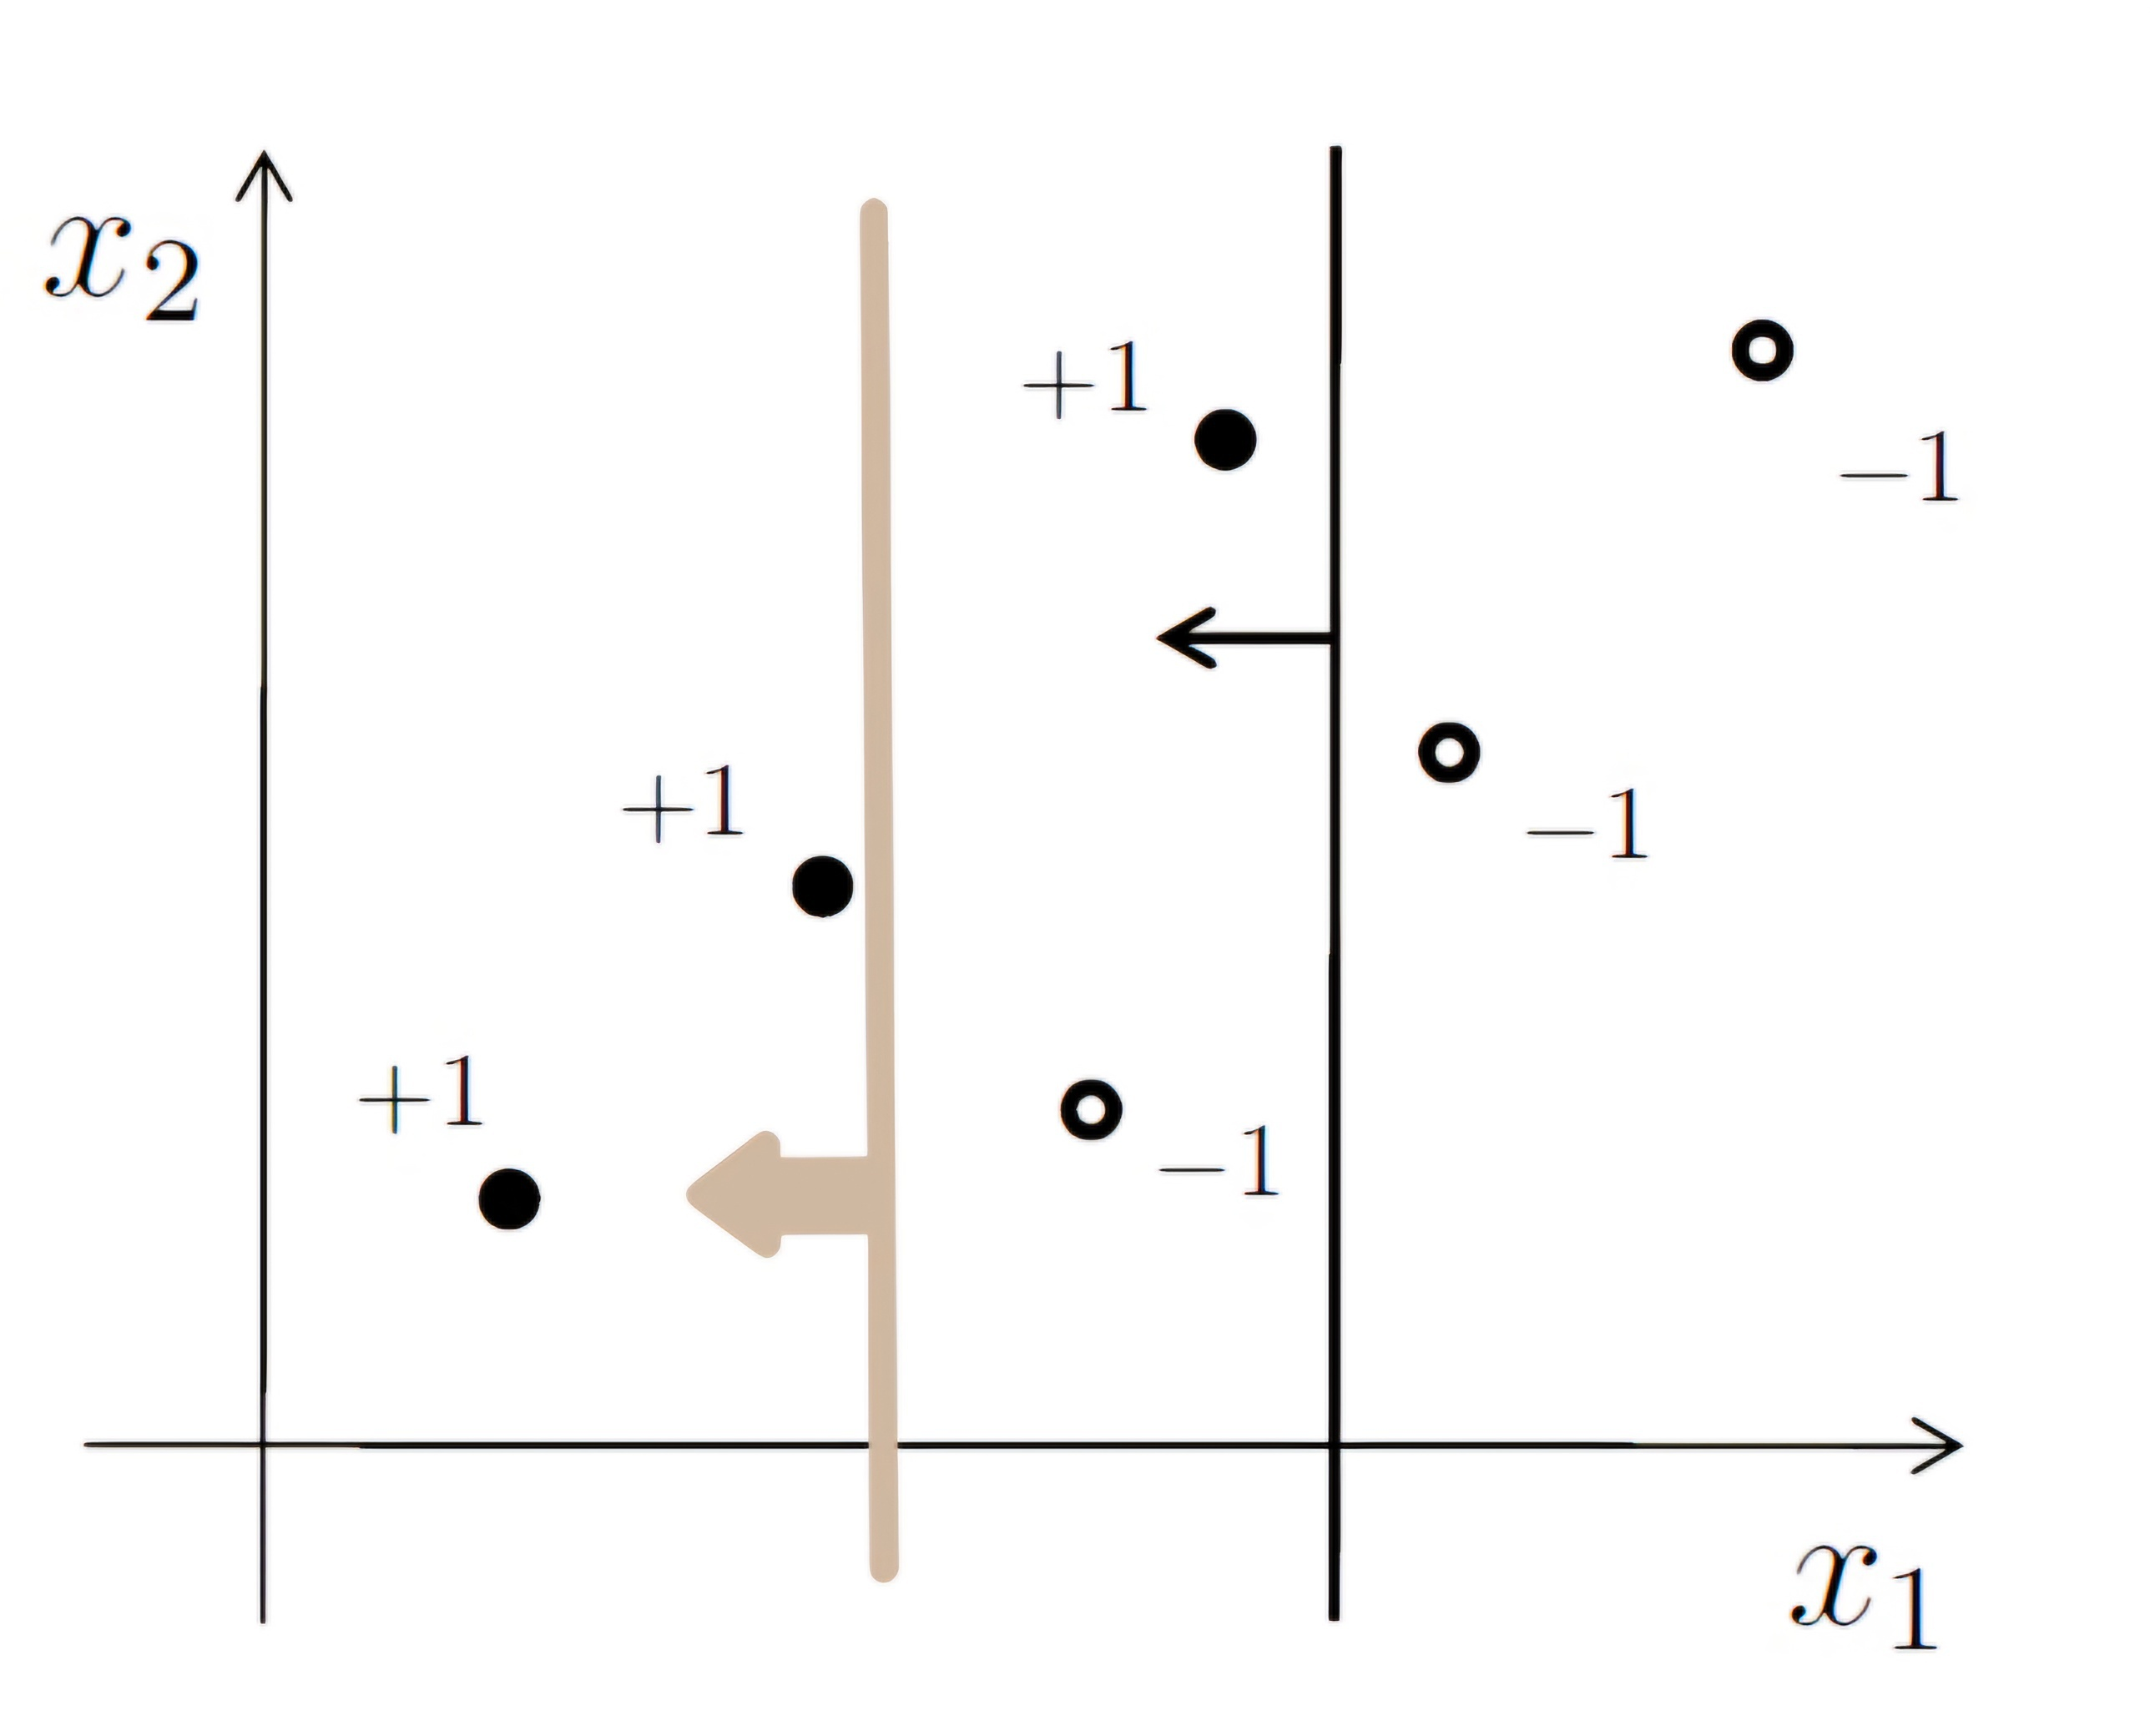


### 4) Comparing Classifier's Weights

Without detailed calculations, $\alpha_2$ will be higher because, with the second decision stump, the heavily weighted $-1$ point is classified correctly. This inference is based on the fact that classifier weights in AdaBoost tend to increase with a decrease in classification error.

### 5) Third Decision Stump

The third decision stump will be represented by the green line, allowing for a more accurate calculation of the full classifier in section 6).

### 6) Full Classifier

The full classifier is expressed as:
$ g(x) = \text{sign}(\alpha_1 f_1(x) + \alpha_2 f_2(x) + \alpha_3 f_3(x)) = 0.79 \cdot f_1(x) + 1.1 \cdot f_2(x) + 0.62 \cdot f_3(x) $

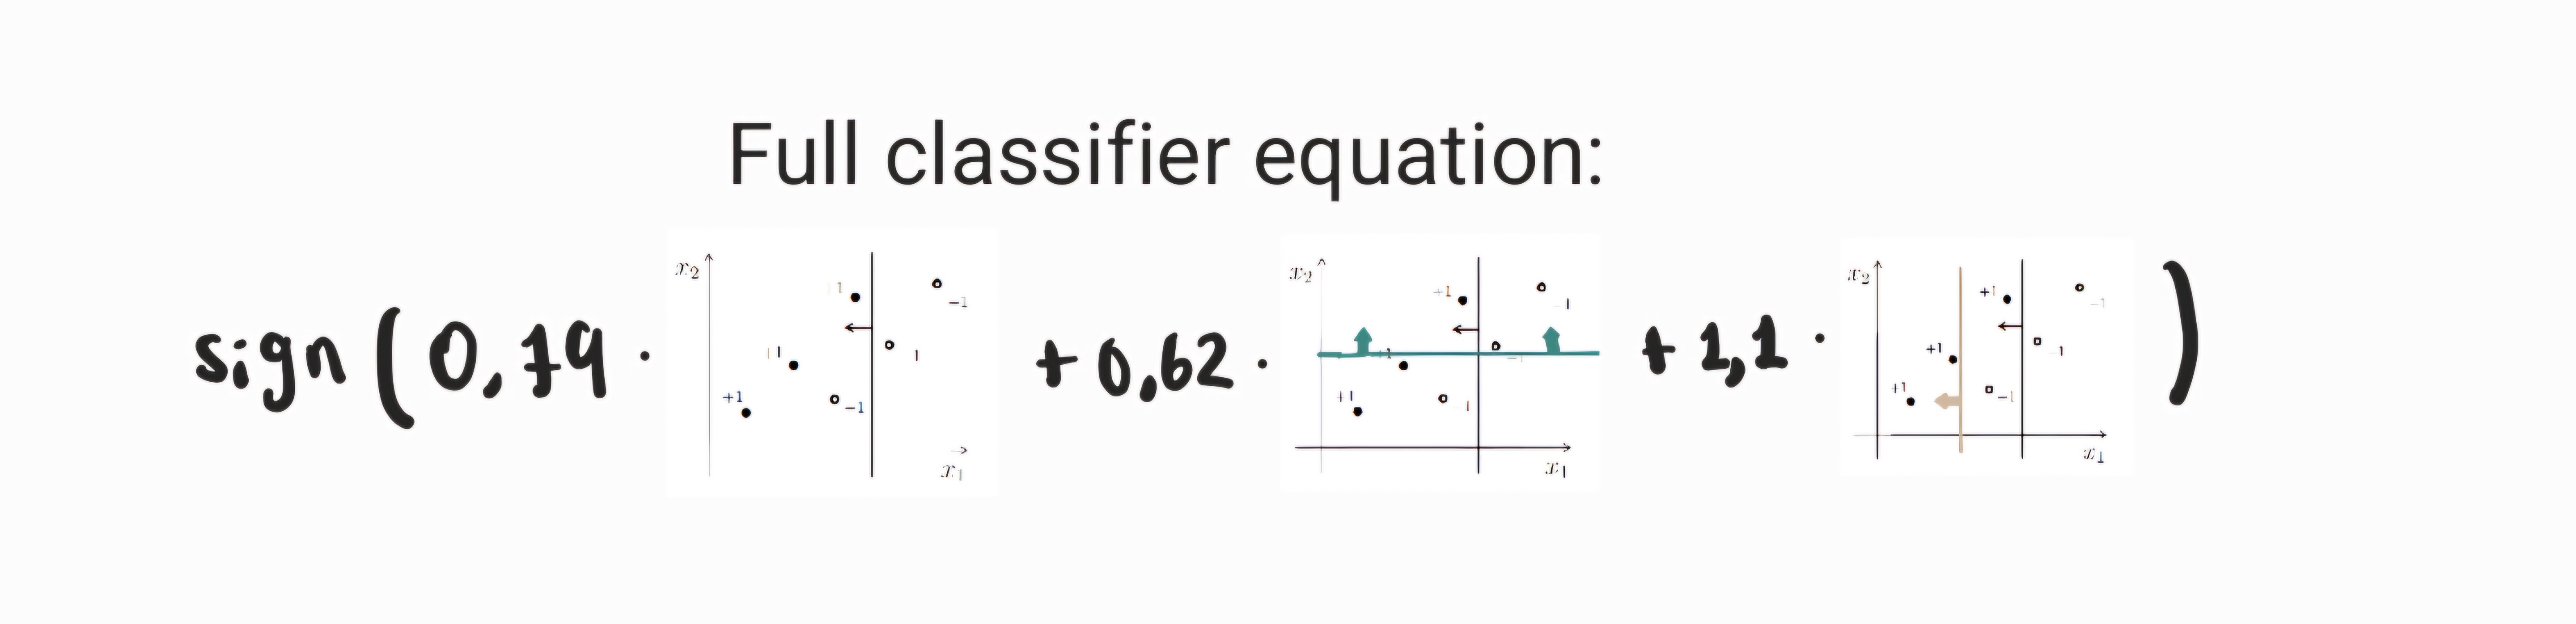
The training accuracy for the first and second stump is:
$ \frac{5}{6} \times 100 \% = 83.3 \% $

For the third stump, the training accuracy is:
$ \frac{2}{6} \times 100\% = 33.3\% $

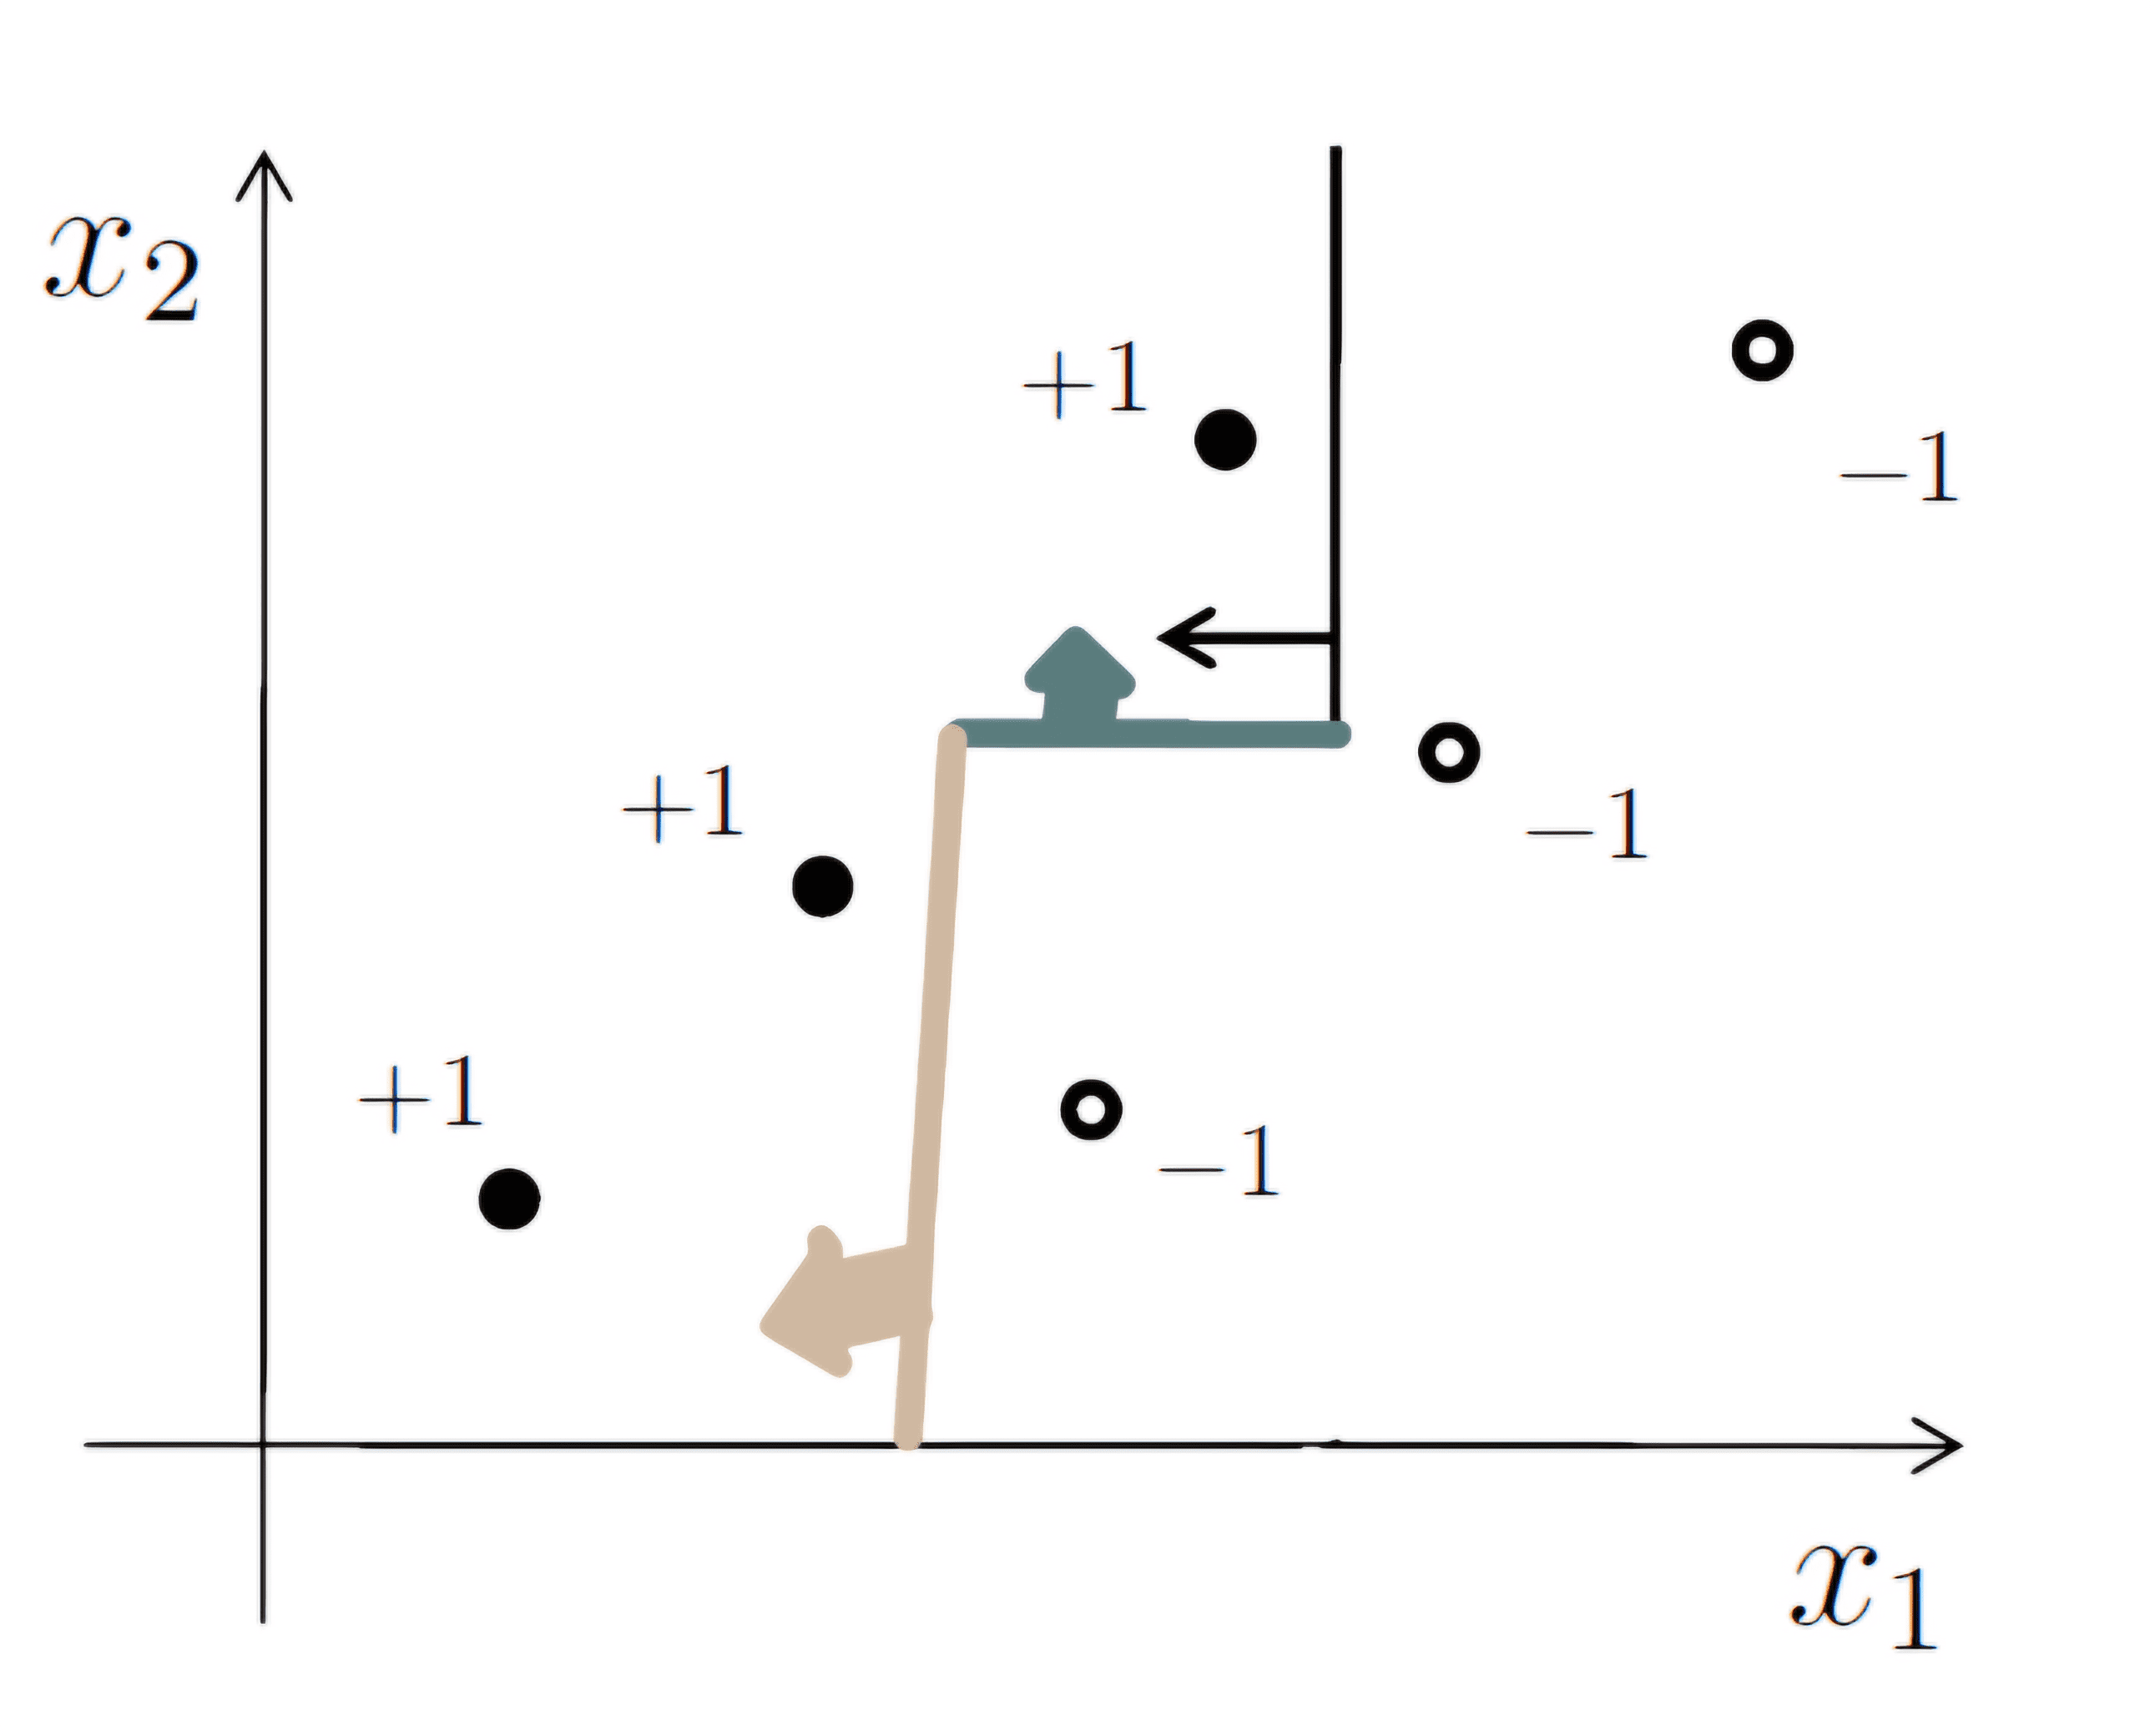

</font>

## Question 5 - Kernel PCA - 10 pts bonus
See attached pdf in moodle assignment! <br/>
Here you will implement the parts that are relevant for that question

<font color='red'>

### Step 1: Mean-Centering in the Feature Space using the Kernel Trick

The mean-centered kernel matrix $K'$ can be computed as:

$$
K' = K - \mathbf{1}_n K - K \mathbf{1}_n + \mathbf{1}_n K \mathbf{1}_n
$$

where $\mathbf{1}_n$ is an $n \times n$ matrix with all elements equal to $\frac{1}{n}$.

### Step 2: Principal Components in the Feature Space

Given that the data is mean-centered in the feature space, the scatter matrix $S$ is given by:

$$
S = \sum_{i=1}^n \phi(x_i) \phi(x_i)^t
$$

The eigenvectors $u_j$ (for $j=1, \ldots, k$) of $S$ can be expressed as a linear combination of $\phi(x_i)$:

$$
u_j = \sum_{i=1}^n \alpha_{ij} \phi(x_i)
$$

### Step 3: Finding $\alpha$

The eigenvalue equation for $S$ is:

$$
S u_j = \lambda_j u_j
$$

Substituting $u_j = \sum_{i=1}^n \alpha_{ij} \phi(x_i)$, we get:

$$
S \left( \sum_{i=1}^n \alpha_{ij} \phi(x_i) \right) = \lambda_j \sum_{i=1}^n \alpha_{ij} \phi(x_i)
$$

Multiplying both sides by $\phi(x_l)^t$:

$$
\phi(x_l)^t S \left( \sum_{i=1}^n \alpha_{ij} \phi(x_i) \right) = \lambda_j \phi(x_l)^t \left( \sum_{i=1}^n \alpha_{ij} \phi(x_i) \right)
$$

This simplifies to:

$$
\sum_{i=1}^n \alpha_{ij} K_{li} = \lambda_j \alpha_{lj}
$$

which in matrix form is:

$$
K \alpha_j = \lambda_j \alpha_j
$$

### Step 4: Projection onto the New Dimension

The projection of $\phi(x)$ onto the new dimension is:

$$
z_j = \langle u_j, \phi(x) \rangle = \sum_{i=1}^n \alpha_{ij} K(x, x_i)
$$

</font>

In [35]:
# **Using the data with high dimensionality of the images in the smiling dataset**

from sklearn.decomposition import KernelPCA
from sklearn.ensemble import AdaBoostClassifier

# Standard PCA
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(x_train_flatten)
X_test_pca = pca.transform(x_test_flatten)

# Kernel PCA with 'cosine' kernel
kpca = KernelPCA(n_components=30, kernel='cosine')
X_train_kpca = kpca.fit_transform(x_train_flatten)
X_test_kpca = kpca.transform(x_test_flatten)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=125)
knn.fit(X_train_pca, y_train)
y_pred_pca = knn.predict(X_test_pca)
accuracy_pca_knn = accuracy_score(y_test, y_pred_pca)

knn.fit(X_train_kpca, y_train)
y_pred_kpca = knn.predict(X_test_kpca)
accuracy_kpca_knn = accuracy_score(y_test, y_pred_kpca)

# AdaBoost Classifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train_pca, y_train)
y_pred_pca_ada = ada.predict(X_test_pca)
accuracy_pca_ada = accuracy_score(y_test, y_pred_pca_ada)

ada.fit(X_train_kpca, y_train)
y_pred_kpca_ada = ada.predict(X_test_kpca)
accuracy_kpca_ada = accuracy_score(y_test, y_pred_kpca_ada)

# Results
results = {
    'KNN with PCA': accuracy_pca_knn,
    'KNN with Kernel PCA': accuracy_kpca_knn,
    'AdaBoost with PCA': accuracy_pca_ada,
    'AdaBoost with Kernel PCA': accuracy_kpca_ada
}

print(results)

{'KNN with PCA': 0.7302904564315352, 'KNN with Kernel PCA': 0.8257261410788381, 'AdaBoost with PCA': 0.8796680497925311, 'AdaBoost with Kernel PCA': 0.8257261410788381}


<font color='red'>

When using KNN with 125 neighbors, Kernel PCA with a 'cosine' kernel performed significantly better on the test set compared to regular PCA. Specifically, the accuracy achieved with Kernel PCA was approximately 82.57%, whereas the accuracy with standard PCA was around 73.03%. This indicates that Kernel PCA is more effective in capturing the underlying structure of the data in this context.

On the other hand, when comparing the performance of AdaBoost on the results of Kernel PCA versus regular PCA, regular PCA demonstrated slightly better generalization. The accuracy with AdaBoost using PCA was about 84.65%, while the accuracy with Kernel PCA was around 82.57%. Despite Kernel PCA performing better with KNN, regular PCA proved to be a better generalizer when used with the AdaBoost classifier.

Kernel PCA outperforms regular PCA when using KNN, but regular PCA is slightly better when using AdaBoost.

</font>